## Principal Component Analysis (PCA) of Basin Characteracteristics

### Data

In this example, we look for patterns in a large sample of watersheds featuring a common set of basin characteristics.  The basins included in the dataset are a subset of the HYSETS database with HYDAT as the source, as these represent basins operated by the Water Survey of Canada.  A later step of the analysis evaluates runoff and basin characteristics for pairs of basins with a minimum length of concurrent data. The HYSETS database contains 2375 basins, and of all ($5.6E6$) basin pair combinations, $2.3E6$ basin pairs meet a minimum of 40 years of concurrent daily flow data.  There are 1030 unique basins in the set of all basin pairs meeting the minimum concurrence.  Of the remaining basins, 759 have a complete set of 15 basin characteristics.  (include discussion about choice of minimum concurrence, provide dataset with varying concurrence threshold criteria.)



### Methodology

The dataset is constructed of $N$ rows corresponding to unique basins and $m$ columns corresponding basin characteristics, represented by the matrix $$\textbf{Y} = \begin{bmatrix}y_{11} & y_{12} & \dots & y_{1m} \\ y_{21} & y_{22} & \dots & y_{2m} \\ \dots & \dots & \dots & \dots \\ y_{N1} & y_{N2} & \dots & y_{Nm} \end{bmatrix}$$

PCA is used to extract uncorrelated modes of variability in the data, on the basis that some more fundamental set of variables $\gamma_1, \gamma_2, \dots$ exists and describes the data (potentially) more concisely.  Following the method of Hotelling (1933), the data is standardized such that each variable (column) has 0 mean and unit variance.  Given $m$ variables and $N$ samples, the objective is to find a matrix $$\textbf{e} = \begin{bmatrix}e_{11} & e_{12} & \dots & e_{1m} \\ e_{21} & e_{22} & \dots & e_{2m} \\ \dots & \dots & \dots & \dots \\ e_{m1} & e_{m2} & \dots & e_{mm} \end{bmatrix}$$ such that $var(z_l) = \sum_{}^{m}$.  

Each mode 



In [1]:
import pandas as pd
import numpy as np

from minisom import MiniSom

import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA, FastICA

from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.plotting import ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3

from bokeh.layouts import gridplot


import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

In [2]:
# raw_df = pd.read_csv('results/results_allPairs_BCAB.csv')
# raw_df = pd.read_csv('results/results1.csv')
basin_df = pd.read_csv('filtered_basins_characteristics.csv')

basin_df = basin_df.sort_values('Centroid_Lon_deg_E')
basin_df.reset_index(inplace=True, drop=True)

# normed_df = (rdf - rdf.min()) / (rdf.max() - rdf.min())
# normed_df.dropna(inplace=True)
# print(f'Analyzing {len(raw_df)} basin pairs.')
print(f'Analyzing {len(basin_df)} basins.')
# print(basin_df.head())

# variables = raw_df.columns
variables = basin_df.columns
# print(variables)
# pca_vars = [e for e in variables if e != 'similarity']
pca_vars = [e for e in variables if e != 'Watershed_ID']

# filter for the basin characteristic columns
df = basin_df[pca_vars].copy()
# normalize the input data
# df = (df - df.min()) / (df.max() - df.min())

df = (df - df.mean()) / df.std()

# check mean and stdev are 0 and 1, respectively
# print(df.mean())
# print(df.std())

Analyzing 759 basins.


In [3]:
df = df[~df.isnull().any(1)]
print(f'For some reason { len(basin_df) - len(df)} basins had nan values. These are removed.')

For some reason 2 basins had nan values. These are removed.


In [4]:
def create_grid_plot(data):
    j = 0
    figs = []
    for char in data.columns:
        p = figure(plot_width=250, plot_height=250, background_fill_color="#fafafa",
                  title=char)
        x = data[char].to_numpy()
        
        hist, edges = np.histogram(x, density=True, bins='auto')
        
        
        p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
        figs.append(p)
    return figs
            
hist_grid = create_grid_plot(df)

In [5]:
show(gridplot(hist_grid, ncols=4, plot_width=200, plot_height=130))

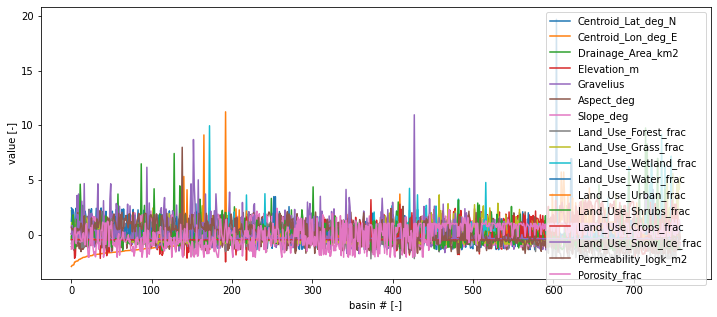

In [6]:
# plot the normalized observation set

ax = df.plot(figsize=(12, 5))

ax.set_xlabel('basin # [-]')
ax.set_ylabel('value [-]')
plt.show()

In [7]:
# do PCA using built-in library
x = df.index.values
y = df.to_numpy()

n_modes = np.shape(y)[1] #dimension of input = 4, so want 4 modes

pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(y)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

In [8]:
print('Input shape = ', np.shape(y))
print('PC shape = ', np.shape(PCs))
print('Eigenvector shape', np.shape(eigvecs))
print('PCA Output Eigenvectors (first):')
print(eigvecs[0])

Input shape =  (757, 17)
PC shape =  (757, 17)
Eigenvector shape (17, 17)
PCA Output Eigenvectors (first):
[ 0.12895813  0.33215008  0.00350443 -0.31146952 -0.04757509 -0.12030993
 -0.42298885 -0.24651835 -0.19030791  0.14642022  0.09606719  0.24059826
 -0.0522965   0.38680188 -0.21136694 -0.35022006  0.27411448]


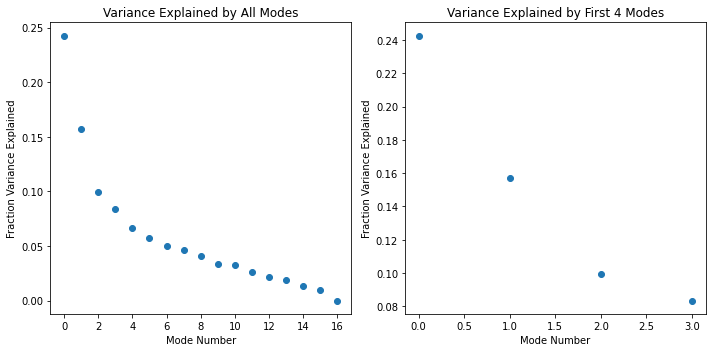

In [9]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 4
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

In [10]:
cumulative_var = 0
for n in range(len(fracVar)):
    cumulative_var += fracVar[n]
    print(f'Mode {n} ({variables[n]}): {fracVar[n]:.2f} (cumulative{cumulative_var:.2f})')

Mode 0 (Centroid_Lat_deg_N): 0.24 (cumulative0.24)
Mode 1 (Centroid_Lon_deg_E): 0.16 (cumulative0.40)
Mode 2 (Drainage_Area_km2): 0.10 (cumulative0.50)
Mode 3 (Elevation_m): 0.08 (cumulative0.58)
Mode 4 (Gravelius): 0.07 (cumulative0.65)
Mode 5 (Aspect_deg): 0.06 (cumulative0.71)
Mode 6 (Slope_deg): 0.05 (cumulative0.76)
Mode 7 (Land_Use_Forest_frac): 0.05 (cumulative0.80)
Mode 8 (Land_Use_Grass_frac): 0.04 (cumulative0.84)
Mode 9 (Land_Use_Wetland_frac): 0.03 (cumulative0.88)
Mode 10 (Land_Use_Water_frac): 0.03 (cumulative0.91)
Mode 11 (Land_Use_Urban_frac): 0.03 (cumulative0.94)
Mode 12 (Land_Use_Shrubs_frac): 0.02 (cumulative0.96)
Mode 13 (Land_Use_Crops_frac): 0.02 (cumulative0.98)
Mode 14 (Land_Use_Snow_Ice_frac): 0.01 (cumulative0.99)
Mode 15 (Permeability_logk_m2): 0.01 (cumulative1.00)
Mode 16 (Porosity_frac): 0.00 (cumulative1.00)


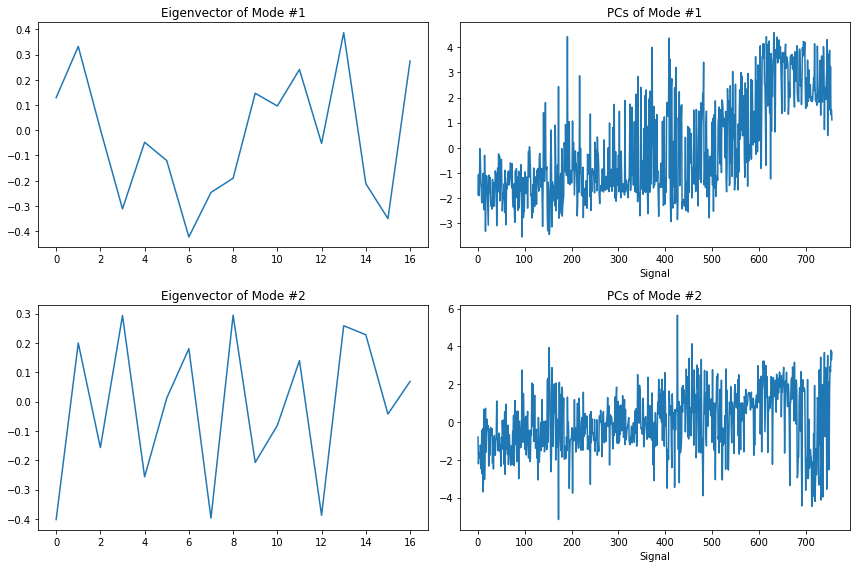

In [11]:
#plot the first n modes and PCs for ~90% of variance
n = 2

plt.figure(figsize=(12,4*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.plot(eigvecs[kk,:])
    plt.title('Eigenvector of Mode #' + str(kk+1))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Signal')
    
    plt.tight_layout()

In [12]:
def calc_PCA_euclidean(row, PCs, m):
    similarity = 0
    for mode in range(m):
        similarity += np.sqrt(((row.to_numpy() - PCs[mode, :])**2).sum())
    return similarity


def calc_PCA_euclidean1(row, PCs, eigvecs, m):
    similarity = 0
#     print(m)
    i = 0
    
    for mode in range(m):
#         foo = ((PCs[row.name, :] * eigvecs[:, mode].T)**2).sum()
        foo = ((PCs[row.name, :] * eigvecs[:, mode].T)**2).sum()
        if foo > 0.:
            pc_sum = np.sqrt(foo)
            similarity += pc_sum
        if foo <= 0.:
            print(foo)
            print(asdfsadf)
        
    return similarity

In [14]:
# for num_modes in range(1, 15):

#     result_df = pd.DataFrame()
#     result_df['similarity'] = raw_df['similarity'].copy()
    
#     result_df['pca_euclidean'] = df.apply(lambda row: calc_PCA_euclidean1(row, PCs, eigvecs, num_modes), axis=1)
    
#     result_df.to_csv(f'results/pca_result_{num_modes}_modes.csv')

$$t( i ) -   t ( j ) = ( t_1 , \dots , t_l ) ( i ) {\displaystyle \mathbf {t}_{(i)}=(t_{1},\dots ,t_{l})_{(i)}}  - ( t_1 , \dots , t_l ) ( j ) {\displaystyle \mathbf {t}_{(i)}=(t_{1},\dots ,t_{l})_{(i)}}$$

In [15]:
pc_df = pd.DataFrame(PCs, columns=[f'PC {e}' for e in range(PCs.shape[1])])
pca_component_grid = create_grid_plot(pc_df)


In [16]:
show(gridplot(pca_component_grid, ncols=4, plot_width=200, plot_height=130))

## Run ICA

Find the modes of maximum statistical independence.

In [18]:
# do ICA using built-in library
x = df.index.values
y = df.to_numpy()

n_modes = np.shape(y)[1] #dimension of input = 4, so want 4 modes

ica = FastICA(n_components=n_modes)
S_ = ica.fit_transform(y)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(y, np.dot(S_, A_.T) + ica.mean_)

# ica = FastICA()
# S_ica_ = ica.fit(y).transform(y)
S_ /= S_.std(axis=0)

In [19]:
ica_df = pd.DataFrame(S_, columns=[f'IC {e}' for e in range(PCs.shape[1])])
ica_component_grid = create_grid_plot(ica_df)

show(gridplot(ica_component_grid, ncols=4, plot_width=200, plot_height=130))

In [ ]:
#run SOM -- this code creates/trains the SOM and calculates stats of interest

nx = 17
ny = 17

#make, initialize, and train the SOM
print(d.shape)
som = MiniSom(nx, ny, d.shape[1], sigma=.5, learning_rate=0.36) # initialization of (ny x nx) SOM
som.pca_weights_init(d)
som.train_random(d, 500) # trains the SOM with 100 iterations

qnt = som.quantization(d) #this is the pattern of the BMU of each observation (ie: has same size as data input to SOM)
bmu_patterns = som.get_weights() #this is the pattern of each BMU; size = (nx, ny, len(data[0]))
QE = som.quantization_error(d) #quantization error of map
TE = som.topographic_error(d) #topographic error of map

#calculate the BMU of each observation
bmus = []
for kk in range(len(d)):
    bmus.append(som.winner(d[kk]))
    
#inds gives the sequential coordinates of each SOM node (useful for plotting)
inds = []
for ii in range(ny):
    for jj in range(nx):
        inds.append((ii,jj))
     

In [ ]:
# compute the frequency of each BMU
freq = np.zeros((nx,ny))
for bmu in bmus:
    freq[bmu[0]][bmu[1]]+=1
freq/=len(d)

In [ ]:
freq

In [ ]:
#visualize
from matplotlib import pylab

fig, ax = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
row, col = 0, 0
for kk in range(nx*ny):   
    indx = inds[kk][1]
    indy = inds[kk][0]
#     plt.imshow(np.reshape(bmu_patterns[indx][indy],(faceH,faceW)).T,cmap='gray')
    ax[col, row].plot(np.reshape(bmu_patterns[indx][indy], (100)).T)
    ax[col, row].set_title('Freq = ' + str(freq[indx][indy]*100)[:4] + '%')

    ax[col, row].set_ylabel('Precipitation (Normalized)')
    ax[col, row].set_xlabel('Percentage of Basin Area')
    col += 1
    if col == ny:
        col = 0
        row += 1
    
    
plt.tight_layout()